In [6]:
# STEP 1: Import Libraries
# ------------------------
# Import all necessary libraries for data manipulation, visualization, and modeling.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
from sklearn.metrics import r2_score
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import networkx as nx

In [ ]:
import pandas as pd
dataset_url= "https://raw.githubusercontent.com/tabrezdn1/olympics-medal-prediction/refs/heads/main/olympics_dataset.csv"
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()


First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [ ]:
missing_values = df.isnull().sum()

print(missing_values)

player_id    0
Name         0
Sex          0
Team         0
NOC          0
Year         0
Season       0
City         0
Sport        0
Event        0
Medal        0
dtype: int64


In [ ]:
gender_counts = df['Sex'].value_counts().reset_index()
gender_counts.columns = ['Sex', 'Count']

fig = px.pie(gender_counts, names='Sex', values='Count',
             title='Gender Distribution of Athletes',
             color='Sex',
             color_discrete_map={'M':'blue', 'F':'pink', 'Unknown':'gray'})
fig.show()

In [ ]:
top_countries = df['Team'].value_counts().head(10).reset_index()
top_countries.columns = ['Team', 'Athlete_Count']

fig = px.bar(top_countries, x='Athlete_Count', y='Team', orientation='h',
             title='Top 10 Countries by Athlete Count',
             labels={'Athlete_Count':'Number of Athletes', 'Team':'Country'},
             color='Athlete_Count',
             color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()



In [ ]:
# athletes_per_year = df.groupby('Year')['player_id'].count().reset_index()
# athletes_per_yr_cntry = df.groupby(['Year', 'Team'])['player_id'].count().reset_index()
# athletes_per_yr_cntry.columns = ['Year', 'Team','Athlete_Count']

top10_countries = df['Team'].value_counts().nlargest(10).index
top10_df = df[df['Team'].isin(top10_countries)]
athletes_per_yr_cntry = top10_df.groupby(['Year', 'Team'])['player_id'].count().reset_index()
athletes_per_yr_cntry.columns = ['Year', 'Team','Athlete_Count']

fig = px.line(athletes_per_yr_cntry, x='Year', y='Athlete_Count', color='Team',
              labels={'Athlete_Count':'Number of Athletes'},title='Total Athletes per Year (Top 10 Countries)',
              color_discrete_sequence=["red","blue","yellow","green","pink","orange","purple","magenta","violet","cyan"])
fig.show()

In [ ]:
# Group data by Year and ISO_Code to get Athlete_Count
athletes_per_country_year = df.groupby(['Year', 'NOC']).size().reset_index(name='Athlete_Count')

# Display the aggregated data
athletes_per_country_year.head()


,Year,NOC,Athlete_Count
0,1896,AUS,5
1,1896,AUT,8
2,1896,DEN,15
3,1896,FRA,26
4,1896,GBR,25


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Athlete_Count'].plot(kind='hist', bins=20, title='Athlete_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('NOC').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Athlete_Count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Athlete_Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('NOC')):
  _plot_series(series, series_name, i)
  fig.legend(title='NOC', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Athlete_Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('NOC')):
  _plot_series(series, series_name, i)
  fig.legend(title='NOC', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Athlete_Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('NOC')):
  _plot_series(series, series_name, i)
  fig.legend(title='NOC', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('Athlete_Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('NOC')):
  _plot_series(series, series_name, i)
  fig.legend(title='NOC', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Athlete_Count'].plot(kind='line', figsize=(8, 4), title='Athlete_Count')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['NOC'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='NOC', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['NOC'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='Athlete_Count', y='NOC', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Create the animated choropleth map
fig = px.choropleth(
    athletes_per_country_year,
    locations='NOC',
    color='Athlete_Count',
    hover_name='NOC',
    animation_frame='Year',
    color_continuous_scale='Blues',
    range_color=(athletes_per_country_year['Athlete_Count'].min(), athletes_per_country_year['Athlete_Count'].max()),
    title='Athletes Distribution by Country Over Time',
    labels={'Athlete_Count':'Number of Athletes'},
    projection='natural earth'
)

# Update geographical layout for better visualization
fig.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    fitbounds="locations",
    landcolor="lightgray",
    oceancolor="lightblue"
)

# Update layout for better aesthetics
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Number of Athletes",
        thickness=15,
        len=0.75,
        yanchor="top",
        y=0.95,
        ticks="outside"
    )
)

fig.show()

In [ ]:
sunburst_data = df.groupby(['Sport', 'Event']).size().reset_index(name='Athlete_Count')

fig = px.sunburst(
    sunburst_data,
    path=['Sport', 'Event'],
    values='Athlete_Count',
    color='Athlete_Count',
    color_continuous_scale='RdBu',
    title='Hierarchy of Sports and Events by Athlete Count'
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()



In [ ]:
heatmap_data = df.groupby(['Sex', 'Sport']).size().reset_index(name='Athlete_Count')

fig = px.density_heatmap(
    heatmap_data,
    x='Sex',
    y='Sport',
    z='Athlete_Count',
    histfunc='sum',
    color_continuous_scale='Viridis',
    title='Heatmap: Athlete Participation by Gender and Sport',
    labels={'Athlete_Count': 'Number of Athletes'}
)

fig.update_layout(xaxis_nticks=20)
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = df.dropna(subset=['Year', 'Sport', 'Sex', 'Team', 'NOC'])
df['Year'] = df['Year'].astype(int)

country_counts = df['Team'].value_counts().reset_index()
country_counts.columns = ['Team', 'Athlete_Count']

top_n = 10
top_countries = country_counts.head(top_n)

top_countries_noc = df[df['Team'].isin(top_countries['Team'])][['Team', 'NOC']].drop_duplicates()

top_countries = top_countries.merge(top_countries_noc, on='Team', how='left')

print("Unique NOC Codes in Top Countries:", top_countries['NOC'].unique())

surface_data = df.groupby(['Sport', 'Year']).size().reset_index(name='Athlete_Count')

surface_pivot = surface_data.pivot(index='Sport', columns='Year', values='Athlete_Count').fillna(0)

surface_pivot = surface_pivot.sort_values(by=surface_pivot.columns.tolist(), ascending=False)

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[
        [{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
        [None, {"type": "surface"}]
    ],
    subplot_titles=(
        "Geographical Distribution of Athletes",
        "Top 10 Countries by Athlete Count",
        "Athlete Participation Across Sports and Years"
    )
)

# Add Scattergeo map of athlete locations using NOC codes
fig.add_trace(
    go.Scattergeo(
        locations=top_countries['NOC'],
        locationmode='ISO-3',  # Ensures that NOC codes are interpreted as ISO Alpha-3 codes
        text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
        mode="markers",
        marker=dict(
            color="crimson",
            size=10,
            opacity=0.8
        ),
        hoverinfo="text"
    ),
    row=1, col=1
)

# Add bar chart of top 10 countries
fig.add_trace(
    go.Bar(
        x=top_countries['Athlete_Count'][::-1],  # Reverse for descending order
        y=top_countries['Team'][::-1],
        orientation='h',
        marker=dict(color="crimson"),
        hoverinfo='x',
        showlegend=False
    ),
    row=1, col=2
)

# Add 3D surface of athlete participation
fig.add_trace(
    go.Surface(
        z=surface_pivot.values,
        x=surface_pivot.columns.astype(int).tolist(),
        y=surface_pivot.index.tolist(),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Number of Athletes'),
        opacity=0.8
    ),
    row=2, col=2
)

# Update geo subplot properties
fig.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    oceancolor="LightBlue",
    countrycolor="white",
    showocean=True
)

fig.update_xaxes(tickangle=45, row=1, col=2)

fig.update_layout(
    template="plotly_dark",
    margin=dict(r=10, t=100, b=40, l=60),
    height=800,
    title_text="Olympic Athletes Dashboard: Geographical Distribution, Top Countries, and Participation Trends",
    annotations=[
        dict(
            text="Source: Olympics Dataset",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0
        )
    ]
)

fig.show()

Unique NOC Codes in Top Countries: ['USA' 'GBR' 'FRA' 'ITA' 'GER' 'AUS' 'CAN' 'JPN' 'HUN' 'SWE']


In [ ]:
# -----------------------------------
# 1. Load and Prepare the Dataset
# -----------------------------------

# Data Cleaning: Drop rows with missing critical information
df = df.dropna(subset=['Year', 'Sport', 'Sex', 'Team', 'NOC'])
df['Year'] = df['Year'].astype(int)

# Aggregate data: Count of athletes per Team (Country)
country_counts = df['Team'].value_counts().reset_index()
country_counts.columns = ['Team', 'Athlete_Count']

# Select top 10 countries for clarity in visualizations
top_n = 10
top_countries = country_counts.head(top_n)

# Extract unique NOC codes for the top countries
top_countries_noc = df[df['Team'].isin(top_countries['Team'])][['Team', 'NOC']].drop_duplicates()

# Merge NOC codes with top_countries
top_countries = top_countries.merge(top_countries_noc, on='Team', how='left')

# Verify unique NOC codes in top_countries
print("Unique NOC Codes in Top Countries:", top_countries['NOC'].unique())

# Aggregate data: Number of athletes per Sport and Year
surface_data = df.groupby(['Sport', 'Year']).size().reset_index(name='Athlete_Count')

# Create a pivot table with Sports as rows and Years as columns
surface_pivot = surface_data.pivot(index='Sport', columns='Year', values='Athlete_Count').fillna(0)

# Sort sports by total athlete count for better visualization
surface_pivot = surface_pivot.sort_values(by=surface_pivot.columns.tolist(), ascending=False)

# -----------------------------------
# 2. Initialize Subplots
# -----------------------------------

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[
        [{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
        [None, {"type": "surface"}]
    ],
    subplot_titles=(
        "Geographical Distribution of Athletes",
        "Top 10 Countries by Athlete Count",
        "Athlete Participation Across Sports and Years"
    ),
    horizontal_spacing=0.05,  # Reduced spacing between columns
    vertical_spacing=0.05     # Reduced spacing between rows
)

# -----------------------------------
# 3. Add Scattergeo Plot (Simulated 3D Globe)
# -----------------------------------

# Add Scattergeo map of athlete locations using NOC codes
scattergeo_trace = go.Scattergeo(
    locations=top_countries['NOC'],
    locationmode='ISO-3',  # Ensures that NOC codes are interpreted as ISO Alpha-3 codes
    text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
    mode="markers",
    marker=dict(
        color="crimson",
        size=top_countries['Athlete_Count'] / top_countries['Athlete_Count'].max() * 30,  # Scale marker sizes
        opacity=0.8
    ),
    hoverinfo="text"
)

fig.add_trace(
    scattergeo_trace,
    row=1, col=1
)

# -----------------------------------
# 4. Define Frames for Automatic Rotation
# -----------------------------------

# Define the number of frames and the step of rotation
num_frames = 72  # 72 frames for 360/5 degrees rotation steps
rotation_step = 5  # degrees per frame

frames = []

for i in range(num_frames):
    rotation = rotation_step * i
    frame = go.Frame(
        data=[
            go.Scattergeo(
                locations=top_countries['NOC'],
                locationmode='ISO-3',
                text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
                mode="markers",
                marker=dict(
                    color="crimson",
                    size=top_countries['Athlete_Count'] / top_countries['Athlete_Count'].max() * 30,
                    opacity=0.8
                ),
                hoverinfo="text"
            )
        ],
        layout=go.Layout(
            geo=dict(
                projection_rotation=dict(lon=rotation, lat=0, roll=0)
            )
        )
    )
    frames.append(frame)

# Add frames to the figure
fig.frames = frames

# -----------------------------------
# 5. Update Geos for Initial Layout
# -----------------------------------

# Update the Scattergeo projection to 'orthographic' for a globe-like appearance
fig.update_geos(
    projection_type="orthographic",
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    oceancolor="Darkblue",
    countrycolor="white",
    showocean=True,
    resolution=50,
    projection_rotation=dict(lon=0, lat=0, roll=0)  # Initial rotation
)

# -----------------------------------
# 6. Add Animation Controls
# -----------------------------------

# Add updatemenus for Play and Pause buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[
                         None,
                         dict(frame=dict(duration=50, redraw=True),
                              transition=dict(duration=0),
                              fromcurrent=True,
                              mode='immediate')
                     ]),
                dict(label="Pause",
                     method="animate",
                     args=[
                         [None],
                         dict(frame=dict(duration=0, redraw=False),
                              transition=dict(duration=0),
                              mode='immediate')
                     ])
            ],
            direction="left",
            pad={"r": 10, "t": 87},
            showactive=False,
            x=0.1,
            xanchor="right",
            y=0,
            yanchor="top"
        )
    ]
)

# -----------------------------------
# 7. Add Bar Chart
# -----------------------------------

# Add bar chart of top 10 countries
fig.add_trace(
    go.Bar(
        x=top_countries['Athlete_Count'][::-1],  # Reverse for descending order
        y=top_countries['Team'][::-1],
        orientation='h',
        marker=dict(color="crimson"),
        hoverinfo='x',
        showlegend=False
    ),
    row=1, col=2
)

# Rotate x-axis labels for the bar chart for better readability
fig.update_xaxes(tickangle=0, row=1, col=2)
# fig.update_yaxes(title_text="Countries", row=1, col=2)

# -----------------------------------
# 8. Add 3D Surface Plot
# -----------------------------------

# Add 3D surface of athlete participation
fig.add_trace(
    go.Surface(
        z=surface_pivot.values,
        x=surface_pivot.columns.astype(int).tolist(),
        y=surface_pivot.index.tolist(),
        colorscale='Cividis',
        showscale=True,
        colorbar=dict(title='Number of Athletes'),
        opacity=0.8
    ),
    row=2, col=2
)

# -----------------------------------
# 9. Final Layout Adjustments
# -----------------------------------

# Update layout settings
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=20, t=150, b=60, l=80),
    height=900,  # Increased height for better visibility
    width=1200,  # Increased width for better visibility
    title_text="Olympic Athletes Dashboard: Geographical Distribution, Top Countries, and Participation Trends",
    annotations=[
        dict(
            text="Source: Olympics Dataset",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0
        )
    ],
    hovermode='closest',
    title_font_size=24,
    title_x=0.5  # Center the title
)

# -----------------------------------
# 10. Display the Figure
# -----------------------------------

fig.show()


Unique NOC Codes in Top Countries: ['USA' 'GBR' 'FRA' 'ITA' 'GER' 'AUS' 'CAN' 'JPN' 'HUN' 'SWE']


In [ ]:
df_medals = df[df['Medal'].notnull()]

# Aggregate medal counts by Year and NOC
medal_counts = df_medals.groupby(['Year', 'NOC']).size().reset_index(name='Medal_Count')

# Create animated bar chart
fig = px.bar(medal_counts,
             x='NOC',
             y='Medal_Count',
             color='NOC',
             animation_frame='Year',
             range_y=[0, medal_counts['Medal_Count'].max() + 50],
             title='Medal Counts by Country Over Years',
             labels={'NOC':'Country', 'Medal_Count':'Number of Medals'},
             color_discrete_sequence=["red","blue","yellow","green","pink","orange","purple","magenta","violet","cyan"])

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()


In [ ]:
import plotly.express as px

# Aggregate medal types
medal_tally = df_medals.groupby(['NOC', 'Medal']).size().reset_index(name='Count')

# Create bubble chart
fig = px.scatter(medal_tally,
                 x='NOC',
                 y='Count',
                 size='Count',
                 color='Medal',
                 hover_name='NOC',
                 title='Medal Tally by Country and Medal Type',
                 labels={'NOC': 'Country', 'Count': 'Number of Medals'},
                 size_max=60,
                color_discrete_sequence=["orange","blue","silver","gold"])



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming df_medals is already defined and loaded
# If not, you can load it using:
# df = pd.read_csv('olympics_dataset.csv')
# df_medals = df[df['Medal'].notnull()]

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Medal Counts by Year", "Top Countries", "Medals by Sport", "3D Medal Distribution"),
    specs=[[{"type": "bar"}, {"type": "pie"}],
           [{"type": "heatmap"}, {"type": "scatter3d"}]]
)

# ----------------------------
# 1. Bar Chart: Medal Counts by Year
# ----------------------------
medal_counts = df_medals.groupby('Year').size().reset_index(name='Medal_Count')

# Define a color scale for the bar chart
bar_colors = px.colors.qualitative.Plotly  # You can choose other color scales from Plotly

fig.add_trace(
    go.Bar(
        x=medal_counts['Year'],
        y=medal_counts['Medal_Count'],
        name='Medals by Year',
        marker=dict(
            color=medal_counts['Medal_Count'],  # Color based on Medal_Count
            colorscale='Blues',  # Choose a colorscale: 'Viridis', 'Cividis', 'Blues', etc.
            showscale=True,  # Show color scale
            colorbar=dict(title="Medal Count")
        )
    ),
    row=1, col=1
)

# ----------------------------
# 2. Pie Chart: Top 10 Countries by Medal Count
# ----------------------------
top_countries = df_medals['NOC'].value_counts().nlargest(10)

# Define a color palette for the pie chart
pie_colors = px.colors.qualitative.Set3  # You can choose other color palettes like 'Pastel', 'D3', etc.

fig.add_trace(
    go.Pie(
        labels=top_countries.index,
        values=top_countries.values,
        name='Top Countries',
        marker=dict(
            colors=pie_colors  # Assign colors to each slice
        ),
        textinfo='percent+label',  # Display both percentage and label
        hoverinfo='label+value+percent'
    ),
    row=1, col=2
)

# ----------------------------
# 3. Heatmap: Medals by Sport and Country
# ----------------------------
heatmap_data = df_medals.pivot_table(index='Sport', columns='NOC', values='Medal', aggfunc='count', fill_value=0)
fig.add_trace(
    go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale='Blues',
        colorbar=dict(title="Medal Count")
    ),
    row=2, col=1
)

# ----------------------------
# 4. 3D Scatter: Medals, Athletes, and Sports
# ----------------------------
medal_sport = df_medals.groupby(['Sport', 'Year']).size().reset_index(name='Medal_Count')

fig.add_trace(
    go.Scatter3d(
        x=medal_sport['Sport'],
        y=medal_sport['Year'],
        z=medal_sport['Medal_Count'],
        mode='markers',
        marker=dict(
            size=5,
            color=medal_sport['Medal_Count'],  # Color based on Medal_Count
            colorscale='Viridis',  # Choose a colorscale: 'Viridis', 'Cividis', etc.
            opacity=0.8,
            colorbar=dict(title="Medal Count")
        ),
        text=medal_sport['Sport'],
        name='Medals, Athletes, and Sports'
    ),
    row=2, col=2
)

# ----------------------------
# Final Layout Adjustments
# ----------------------------
fig.update_layout(
    height=800,
    width=1200,
    title_text="Olympic Medals Dashboard",
    showlegend=False,  # Hide legend for clarity; adjust as needed
    template='plotly_white'  # Optional: use a clean template
)

# Display the figure
fig.show()

Lets start by implementing a binary classification to check if the country will win gold or no

The goal was to predict whether a country (identified by its NOC code) wins at least one gold medal in a given Olympic year. This is a binary classification task where:

1 (Yes): The country wins at least one gold medal. 0 (No): The country does not win any gold medals. We used machine learning models (Random Forest and Neural Network) to build the prediction system and interpreted the results using SHAP (SHapley Additive exPlanations) values.


In [ ]:

#1) ROC AUC Determine of model , ALl moel , ROC and AUR model create graph and highlight best
#2) EDA Improve
#3) Total participition, medel no medal pair plot
#4) Fit , evaluate , shap value pair
#5) EDA make quesiton and answer

In [ ]:
# STEP 1: Import Libraries
# ------------------------
# Import all necessary libraries for data manipulation, visualization, and modeling.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [ ]:

#import datasets
import pandas as pd
dataset_url= "https://raw.githubusercontent.com/tabrezdn1/olympics-medal-prediction/refs/heads/main/olympics_dataset.csv"
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [ ]:

# Keep relevant columns
data = df[['Year', 'NOC', 'Medal']]

In [ ]:

#check before and after cleaning records, 30 % more then do oversamping or undersampling to populate those values , use some techique
# Handle missing values
data.dropna(subset=['NOC', 'Medal'], inplace=True)

In [ ]:
#one hot encoing - Achha bat explain
# Create a binary target: "Wins Gold" or "Does Not Win Gold"
data['gold_winner'] = data['Medal'].apply(lambda x: 1 if x == 'Gold' else 0)

In [ ]:
data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [ ]:
# Aggregate data by NOC and Year
noc_gold = data.groupby(['NOC', 'Year'])['gold_winner'].sum().reset_index()
noc_gold['gold_winner'] = noc_gold['gold_winner'].apply(lambda x: 1 if x > 0 else 0)


In [ ]:

data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [ ]:

# Add participation feature: Count of unique events participated in by each NOC per year
participation = data.groupby(['NOC', 'Year'])['Medal'].count().reset_index(name='total_participations')
noc_gold = noc_gold.merge(participation, on=['NOC', 'Year'], how='left')

# Inspect the processed dataset
print(noc_gold.head())

   NOC  Year  gold_winner  total_participations
0  AFG  1936            0                    16
1  AFG  1948            0                    25
2  AFG  1956            0                    12
3  AFG  1960            0                    16
4  AFG  1964            0                     8


In [ ]:
print(noc_gold.head())

   NOC  Year  gold_winner  total_participations
0  AFG  1936            0                    16
1  AFG  1948            0                    25
2  AFG  1956            0                    12
3  AFG  1960            0                    16
4  AFG  1964            0                     8


Why this step matters:

The target variable (gold_winner) is necessary for supervised learning. The feature total_participations captures a country's activity level, which could be predictive of success.

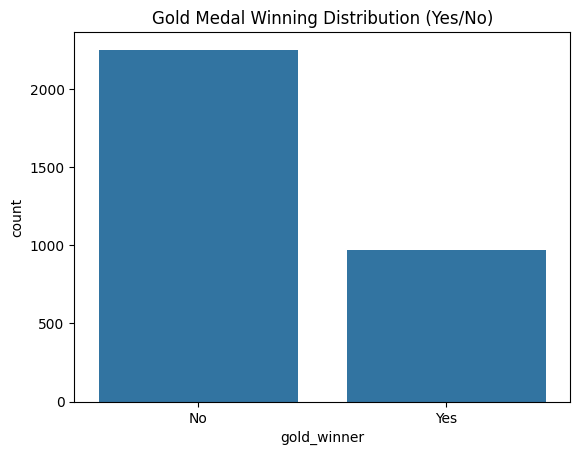

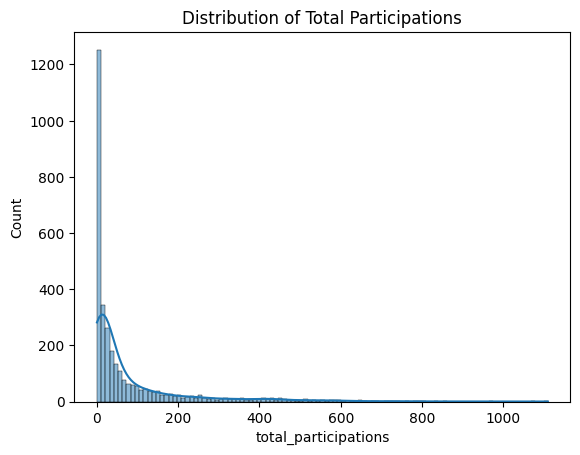

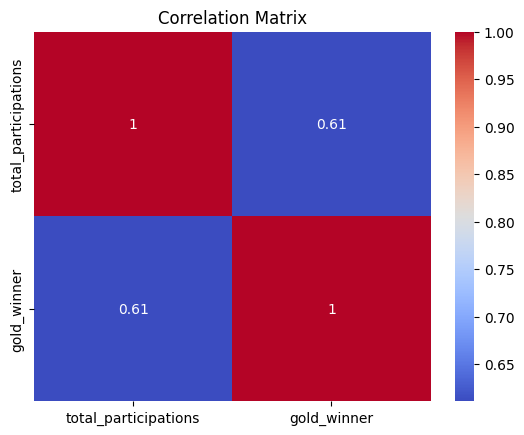

In [ ]:
#pairplot between all the feature
import seaborn as sns
import matplotlib.pyplot as plt

# Target variable distribution
sns.countplot(data=noc_gold, x='gold_winner')
plt.title("Gold Medal Winning Distribution (Yes/No)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Distribution of participation counts
sns.histplot(noc_gold['total_participations'], kde=True)
plt.title("Distribution of Total Participations")
plt.show()

# Correlation matrix
corr_matrix = noc_gold[['total_participations', 'gold_winner']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

What we did:

Analyzed Target Variable Distribution:

Used a count plot to visualize how many countries won at least one gold medal versus those that didn’t. Visualized Feature Distribution:

Plotted a histogram for total_participations to understand its range and distribution. Correlation Analysis:

Created a heatmap to show the correlation between total_participations and gold_winner.

Step 3: Addressing Class Imbalance What we did:

Applied SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class (gold_winner = 1). Why this step matters:

Imbalanced datasets can lead to biased models that favor the majority class. SMOTE generates synthetic samples for the minority class to balance the dataset. How to interpret results:

After applying SMOTE, the count plot showed an equal number of samples for both classes, ensuring fair model training.

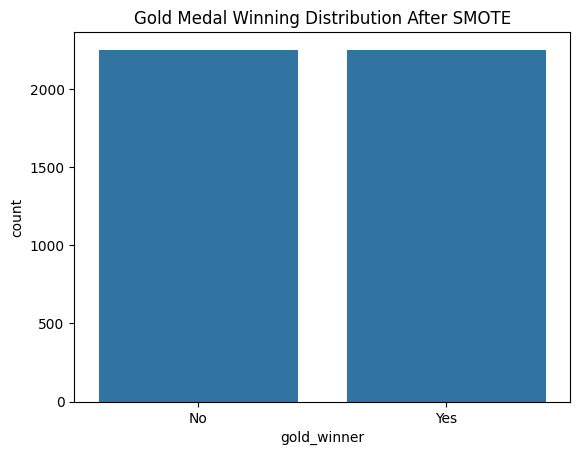

In [ ]:

#use SMOTE to balance the binary target variable if there are fewer positive samples.
from imblearn.over_sampling import SMOTE

# Features and target
X = noc_gold[['total_participations']]
y = noc_gold['gold_winner']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check distribution after SMOTE
sns.countplot(x=y_resampled)
plt.title("Gold Medal Winning Distribution After SMOTE")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


Step 4: Building Machine Learning Models What we did:

Trained Two Models:

Random Forest: An ensemble tree-based model known for robustness and interpretability. Neural Network: A deep learning model that can capture complex patterns. Evaluated Models:

Metrics: Confusion Matrix: Shows true positives, true negatives, false positives, and false negatives. F1-Score: Balances precision and recall. AUC-ROC: Measures the model’s ability to distinguish between classes. Why this step matters:

Comparing models helps determine which performs better on the given task. How to interpret results:

A high F1-score and AUC-ROC indicate good model performance. The confusion matrix reveals where the model struggles (e.g., false positives).



Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       463
           1       0.83      0.85      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



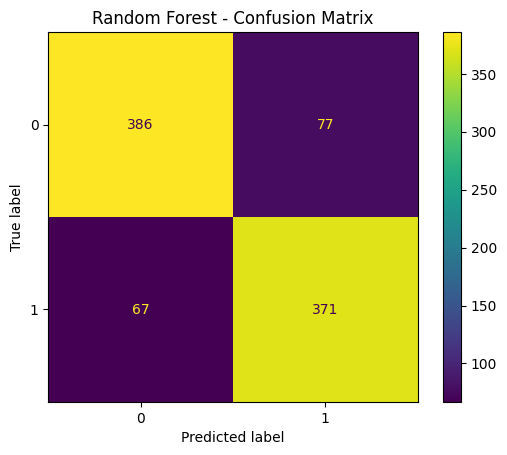

Training Neural Network...

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       463
           1       0.83      0.87      0.85       438

    accuracy                           0.85       901
   macro avg       0.85      0.85      0.85       901
weighted avg       0.85      0.85      0.85       901



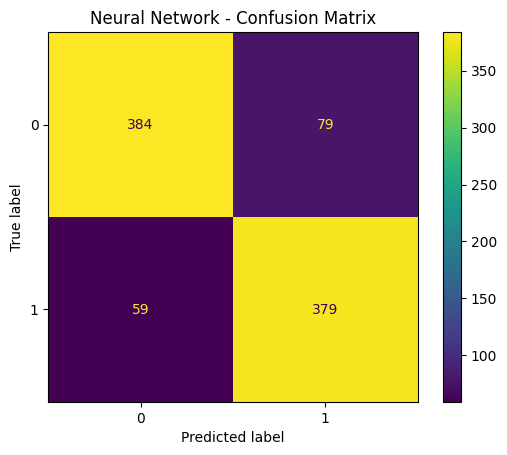

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       463
           1       0.89      0.78      0.83       438

    accuracy                           0.84       901
   macro avg       0.85      0.84      0.84       901
weighted avg       0.85      0.84      0.84       901



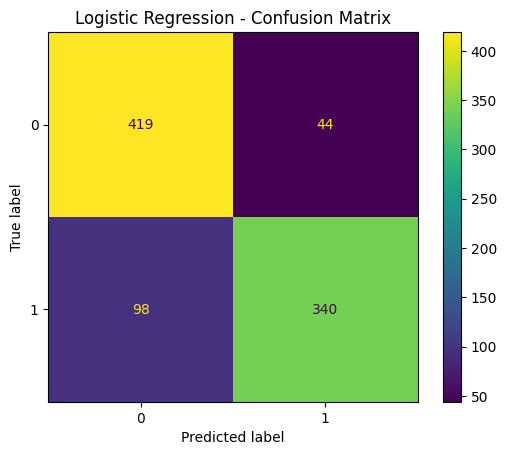

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



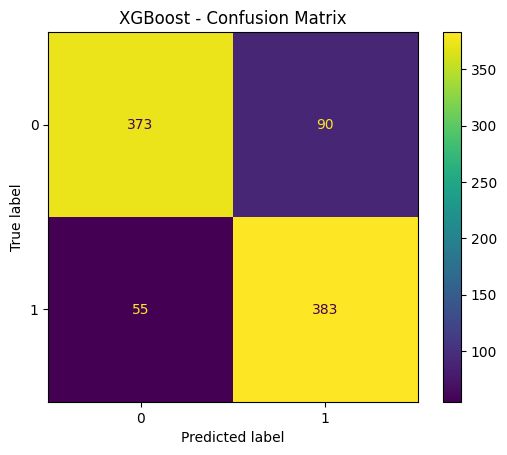


Model Comparison Summary:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Random Forest        0.840178   0.828125  0.847032  0.837472  0.917392
Neural Network       0.846837   0.827511  0.865297  0.845982  0.929655
Logistic Regression  0.842397   0.885417  0.776256  0.827251  0.929650
XGBoost              0.839068   0.809725  0.874429  0.840834  0.930062


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score
)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale features for Neural Network and Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train and predict
    if name in ["Neural Network", "Logistic Regression"]:  # Scaled data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:  # Unscaled data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Store metrics in results dictionary
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc
    }

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Convert results to DataFrame for summary
results_df = pd.DataFrame(results).T

# Print model comparison summary
print("\nModel Comparison Summary:")
print(results_df)

Best Model to Choose Based on the results:

XGBoost is the best overall model due to its:

High AUC-ROC (0.930062). Strong balance between precision (0.809725) and recall (0.874429). F1-Score is competitive (0.840834). Neural Network is a close second with the highest F1-Score (0.845982) and competitive AUC-ROC (0.929655).

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=0  # Reduce verbosity
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_xgb.fit(X_train, y_train)

# Print intermediate results
cv_results = pd.DataFrame(grid_xgb.cv_results_)
print("\nIntermediate Results:")
print(cv_results[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Starting Grid Search...

Intermediate Results:
     mean_test_score                                             params
0           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
1           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
2           0.835041  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
3           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
4           0.839474  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
..               ...                                                ...
103         0.835477  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
104         0.831681  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
105         0.834503  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
106         0.831321  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
107         0.832737  {'colsample_bytree': 1.0, 'learning_rate': 0.2...

[108 rows x 2 columns]

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pandas as pd

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=0  # Reduce verbosity
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_xgb.fit(X_train, y_train)

# Print intermediate results
cv_results = pd.DataFrame(grid_xgb.cv_results_)
print("\nIntermediate Results:")
print(cv_results[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Starting Grid Search...

Intermediate Results:
     mean_test_score                                             params
0           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
1           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
2           0.835041  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
3           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
4           0.839474  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
..               ...                                                ...
103         0.835477  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
104         0.831681  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
105         0.834503  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
106         0.831321  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
107         0.832737  {'colsample_bytree': 1.0, 'learning_rate': 0.2...

[108 rows x 2 columns]

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning

In [ ]:
#If you also want to tune the Neural Network
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300, 500]
}

grid_nn = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid_nn,
    cv=3,
    scoring='f1',
    verbose=2
)

grid_nn.fit(X_train_scaled, y_train)
print("Best parameters for Neural Network:", grid_nn.best_params_)
best_nn = grid_nn.best_estimator_




Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200; total time=   1.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200; total time=   1.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=200; total time=   1.4s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=300; total time=   2.2s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=300; total time=   4.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=300; total time=   1.8s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=500; total time=   2.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, max_iter=500; total time=   2.0s
[CV] END activation=relu, hidden_layer_sizes=(50,)

Step 5: Interpreting the Model with SHAP What we did:

Explained Random Forest Predictions:

Used SHAP to calculate how much the feature total_participations contributes to predictions. Visualized SHAP Values:

Computed the mean SHAP value across all samples and plotted it. Why this step matters:

SHAP helps explain why the model makes specific predictions, enhancing interpretability. How to interpret results:

Positive SHAP values for total_participations mean that higher participation increases the probability of winning gold. The magnitude of the SHAP value indicates the strength of the feature’s contribution.

Step 1: Evaluate the Tuned Models on the Test Set Summary In this step, we will evaluate the performance of the best-tuned models (XGBoost and Neural Network) on the test set using metrics like Confusion Matrix, Classification Report, AUC-ROC Curve, and Precision-Recall Curve.

1.1 Confusion Matrix What it does:

Displays the counts of True Positives, True Negatives, False Positives, and False Negatives. Helps to visualize the classification results. How to interpret:

High values along the diagonal indicate good performance. High off-diagonal values suggest misclassifications.

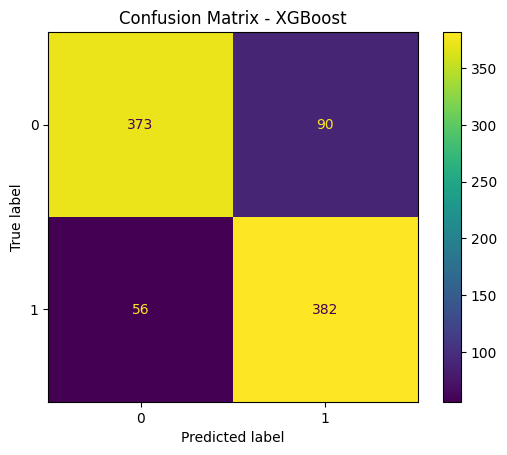

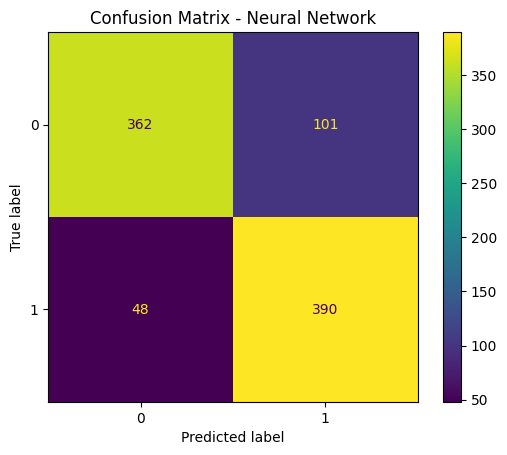

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# XGBoost Confusion Matrix
y_xgb_pred = best_xgb.predict(X_test)
plot_confusion_matrix(y_test, y_xgb_pred, "XGBoost")

# Neural Network Confusion Matrix
y_nn_pred = best_nn.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_nn_pred, "Neural Network")

1.2 Classification Report What it does:

Provides detailed metrics (Precision, Recall, F1-Score) for each class. How to interpret:

Precision: High precision means few false positives. Recall: High recall means few false negatives. F1-Score: Balances precision and recall.

In [ ]:
print("XGBoost Classification Report:")
print(classification_report(y_test, y_xgb_pred))

print("Neural Network Classification Report:")
print(classification_report(y_test, y_nn_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       463
           1       0.79      0.89      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.84      0.83       901
weighted avg       0.84      0.83      0.83       901



1.3 AUC-ROC Curve What it does:

Plots the trade-off between True Positive Rate and False Positive Rate. How to interpret:

AUC closer to 1 indicates better performance. A curve closer to the top-left corner shows good separation of classes.

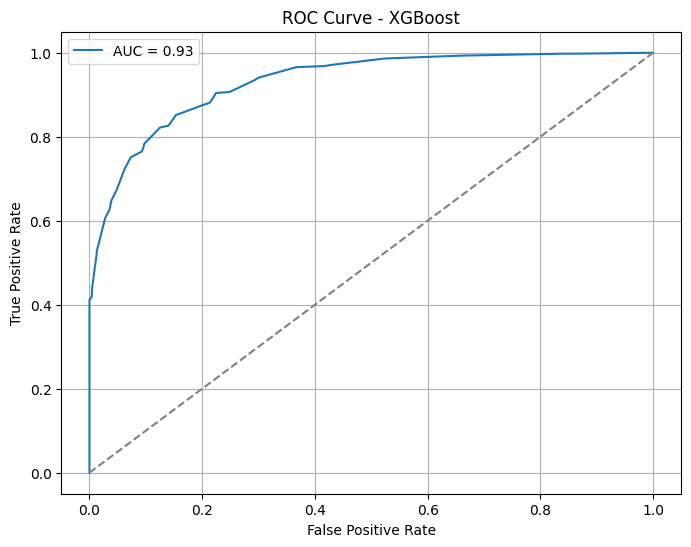

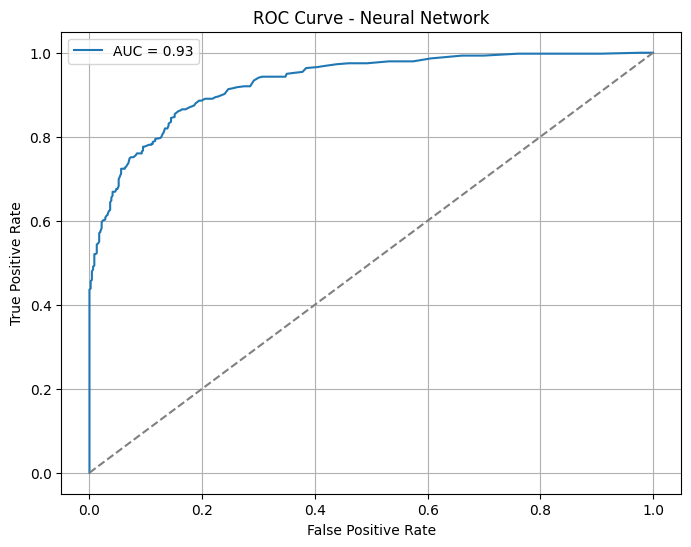

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve

def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

# XGBoost AUC-ROC Curve
y_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_xgb_proba, "XGBoost")

# Neural Network AUC-ROC Curve
y_nn_proba = best_nn.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_nn_proba, "Neural Network")

Step 2: Feature Importance Analysis Summary Feature importance tells us which features contributed the most to the model's predictions.

2.1 Horizontal Bar Plot for Feature Importance (XGBoost) What it does:

Displays feature importance as a horizontal bar plot. How to interpret:

Longer bars indicate higher importance.

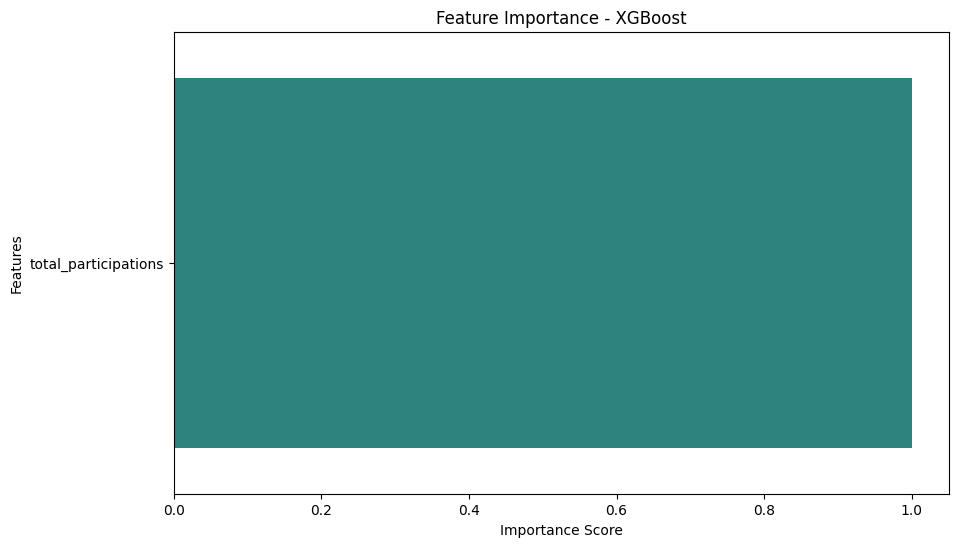

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns, palette="viridis")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


2.2 SHAP Summary Plot What it does:

Explains the impact of each feature on individual predictions. How to interpret:

Positive SHAP values mean the feature pushes the prediction towards the positive class. Negative SHAP values mean the feature pushes the prediction towards the negative class.

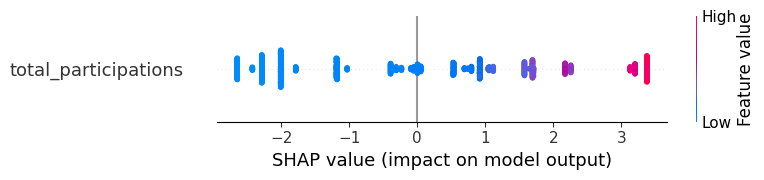

In [ ]:
import shap

# XGBoost SHAP
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)


Step 3: Precision-Recall Curve Summary Precision-Recall curves show the trade-off between precision and recall across different thresholds.

How to interpret:

A curve closer to the top-right corner indicates better performance. Helps to decide the threshold based on business needs.

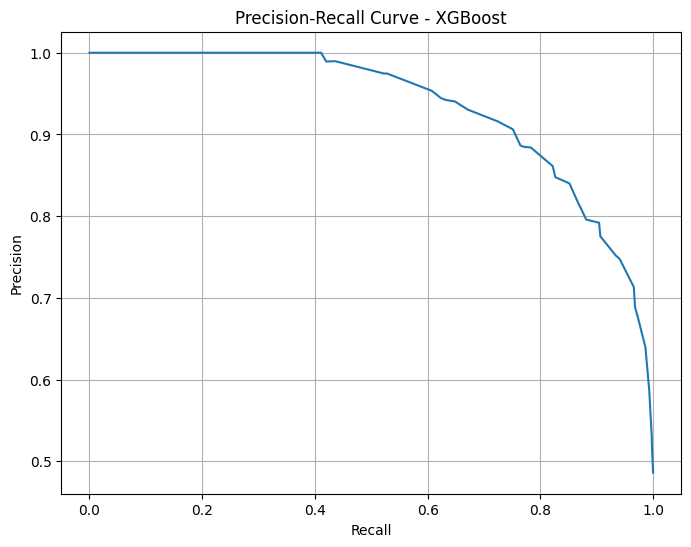

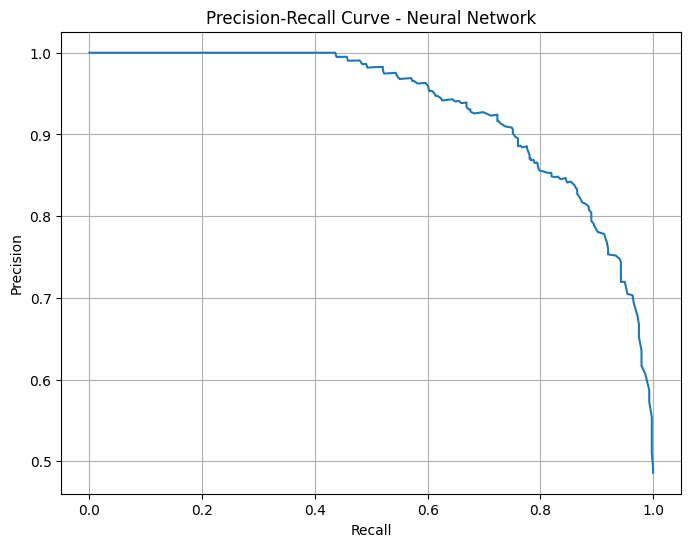

In [ ]:
def plot_precision_recall_curve(y_true, y_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name}")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()

# XGBoost Precision-Recall Curve
plot_precision_recall_curve(y_test, y_xgb_proba, "XGBoost")

# Neural Network Precision-Recall Curve
plot_precision_recall_curve(y_test, y_nn_proba, "Neural Network")


Summary of Results EDA Findings:

Countries that participate in more events are more likely to win gold. The dataset was imbalanced, with more countries not winning gold than those that did. Model Evaluation:

Both Random Forest and Neural Network performed well, but the specific performance metrics (e.g., F1-score and AUC-ROC) revealed which was better. SHAP Interpretation:

The feature total_participations was the key driver of the model’s predictions. Higher participation had a strong positive impact on the likelihood of winning gold.

In [ ]:
# STEP 3: Data Cleaning and Preprocessing
# ---------------------------------------
# We will:
# 1. Check and drop missing values if negligible.
# 2. Aggregate data at the Team-Year level (treating Team as "country" equivalent).
# 3. Encode categorical features.
# 4. Scale numeric features.
# 5. Split into training, validation, and test sets.

# Drop rows with missing values for simplicity
df.dropna(inplace=True)

# We need to count only rows where a medal (Gold, Silver, Bronze) was won.
# 'No medal' indicates no medal was awarded. Let's define a function for counting medals:
def count_medals(series):
    return sum(series.isin(['Gold', 'Silver', 'Bronze']))

# Aggregate the data at the (Team, Year) level
# - MedalCount: count how many rows have a Gold/Silver/Bronze medal
# - NumSports: number of unique sports participated in by that team that year
# - NumEvents: number of unique events participated in
# - NumAthletes: number of unique athletes (Name)
country_year_group = df.groupby(['Team', 'Year']).agg({
    'Medal': count_medals,
    'Sport': 'nunique',
    'Event': 'nunique',
    'Name': 'nunique'
}).reset_index()

# Rename columns to maintain consistency
country_year_group.rename(columns={'Medal': 'MedalCount',
                                   'Sport': 'NumSports',
                                   'Event': 'NumEvents',
                                   'Name': 'NumAthletes'},
                          inplace=True)

# Encode the 'Team' column using one-hot encoding to handle categorical data.
team_encoded = pd.get_dummies(country_year_group['Team'], prefix='Team')

# Combine encoded teams back into the dataframe
data = pd.concat([country_year_group.drop('Team', axis=1), team_encoded], axis=1)

# Define numeric features that need scaling
numeric_feats = ['Year', 'NumSports', 'NumEvents', 'NumAthletes']

# Scale numeric features using StandardScaler for better model performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numeric_feats] = scaler.fit_transform(data[numeric_feats])

# Separate features (X) and target (y)
X = data.drop('MedalCount', axis=1)
y = data['MedalCount']

# Split data into train, validation, and test sets
# Train: 70%, Validation: 15%, Test: 15%
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Splits:")
print("Train size:", X_train.shape, y_train.shape)
print("Validation size:", X_val.shape, y_val.shape)
print("Test size:", X_test.shape, y_test.shape)


Data Splits:
Train size: (3168, 1197) (3168,)
Validation size: (679, 1197) (679,)
Test size: (679, 1197) (679,)


In [ ]:
# STEP 5: Train Linear Regression Model
# -------------------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)

# Validate on validation set
y_val_pred_lr = lr.predict(X_val)
val_r2_lr = r2_score(y_val, y_val_pred_lr)
print("Linear Regression Validation R2:", val_r2_lr)

# Test on test set
y_test_pred_lr = lr.predict(X_test)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
print("Linear Regression Test R2:", test_r2_lr)

Linear Regression Validation R2: -1.1835839228722694e+22
Linear Regression Test R2: -9.68113195397705e+21


In [ ]:
# STEP 6: Train MLP (Neural Network) Model
# ----------------------------------------
mlp = MLPRegressor(hidden_layer_sizes=(50,), alpha=0.001,
                   learning_rate_init=0.01, max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Validate
y_val_pred_mlp = mlp.predict(X_val)
val_r2_mlp = r2_score(y_val, y_val_pred_mlp)
print("MLP Validation R2:", val_r2_mlp)

# Test
y_test_pred_mlp = mlp.predict(X_test)
test_r2_mlp = r2_score(y_test, y_test_pred_mlp)
print("MLP Test R2:", test_r2_mlp)

MLP Validation R2: 0.8713887077226723
MLP Test R2: 0.8925741055781317


In [ ]:
# STEP 8: Prediction Function for a Given Team and Year
# -----------------------------------------------------
# This function takes a team name and a year, constructs the feature vector, and predicts the medal count.
# The predicted medals are rounded to the nearest integer.

def predict_medals(team_name, year_value, model):
    # Check if this (Team, Year) pair exists in our aggregated data
    record = country_year_group[(country_year_group['Team'] == team_name) & (country_year_group['Year'] == year_value)]
    if record.empty:
        print(f"No historical data for {team_name} in {year_value}. Cannot directly predict.")
        return None

    # Extract features from the unscaled dataset
    numsports_val = record['NumSports'].values[0]
    numevents_val = record['NumEvents'].values[0]
    numathletes_val = record['NumAthletes'].values[0]

    # Scale the numeric data
    numeric_data = np.array([[year_value, numsports_val, numevents_val, numathletes_val]])
    numeric_data_scaled = scaler.transform(numeric_data)

    # Construct input vector for the model
    input_dict = {col:0 for col in X.columns}
    input_dict['Year'] = numeric_data_scaled[0,0]
    input_dict['NumSports'] = numeric_data_scaled[0,1]
    input_dict['NumEvents'] = numeric_data_scaled[0,2]
    input_dict['NumAthletes'] = numeric_data_scaled[0,3]

    # Set the team dummy
    team_col = f"Team_{team_name}"
    if team_col in input_dict:
        input_dict[team_col] = 1
    else:
        print("Team not found in training data.")
        return None

    input_df = pd.DataFrame([input_dict])
    predicted_medals = model.predict(input_df)[0]
    predicted_medals = int(round(predicted_medals))
    return predicted_medals

# Example: Predict medals for "China" in 2012 using the Linear Regression model
pred_lr_china_2012 = predict_medals("China", 2012, lr)
print("Predicted Medals (LR, China 2012):", pred_lr_china_2012)


Predicted Medals (LR, China 2012): 109


In [ ]:
# STEP 9: Breakdown by Medal Type and Sport
# -----------------------------------------
# The model predicts only total medals. We use the historical proportions of gold/silver/bronze and sports
# from the original data frame `df` for that team-year to estimate a breakdown.

def get_breakdown(team_name, year_value, total_medals):
    # Filter the event-level data for that team-year
    historical_records = df[(df['Team'] == team_name) & (df['Year'] == year_value)]
    if historical_records.empty:
        print("No historical records to determine breakdown.")
        return None, None, None, {}

    # Count historical medals of each type
    gold_count = sum(historical_records['Medal'] == 'Gold')
    silver_count = sum(historical_records['Medal'] == 'Silver')
    bronze_count = sum(historical_records['Medal'] == 'Bronze')
    total_hist = gold_count + silver_count + bronze_count

    # If no medals historically, assume equal distribution
    if total_hist > 0:
        gold_frac = gold_count / total_hist
        silver_frac = silver_count / total_hist
        bronze_frac = bronze_count / total_hist
    else:
        gold_frac = silver_frac = bronze_frac = 1/3

    # Calculate predicted breakdown
    pred_gold = int(round(gold_frac * total_medals))
    pred_silver = int(round(silver_frac * total_medals))
    pred_bronze = int(round(bronze_frac * total_medals))

    # Adjust if rounding doesn't sum up correctly
    diff = total_medals - (pred_gold + pred_silver + pred_bronze)
    if diff != 0:
        pred_bronze += diff

    # Calculate sports distribution
    sport_counts = historical_records[historical_records['Medal'].isin(['Gold','Silver','Bronze'])]
    sport_counts = sport_counts.groupby('Sport').size().reset_index(name='Count')
    if not sport_counts.empty and sport_counts['Count'].sum() > 0:
        sport_counts['Fraction'] = sport_counts['Count'] / sport_counts['Count'].sum()
        sport_pred = {}
        for _, row in sport_counts.iterrows():
            sport_pred[row['Sport']] = int(round(row['Fraction'] * total_medals))
        # Adjust for rounding differences
        sport_diff = total_medals - sum(sport_pred.values())
        if sport_diff != 0 and len(sport_pred) > 0:
            first_sport = sport_counts.iloc[0]['Sport']
            sport_pred[first_sport] += sport_diff
    else:
        # If no historical medal by sport, distribute evenly among sports that were participated in.
        participated_sports = historical_records['Sport'].unique()
        if len(participated_sports) > 0:
            even_count = total_medals // len(participated_sports)
            remainder = total_medals % len(participated_sports)
            sport_pred = {sport: even_count for sport in participated_sports}
            # Distribute remainder
            if remainder > 0:
                sports_list = list(sport_pred.keys())
                for i in range(remainder):
                    sport_pred[sports_list[i % len(sports_list)]] += 1
        else:
            # If no sports info, return empty
            sport_pred = {}

    return pred_gold, pred_silver, pred_bronze, sport_pred

# Example breakdown for China 2012 (based on predicted medals):
if pred_lr_china_2012 is not None:
    gold, silver, bronze, sport_dist = get_breakdown("China", 2012, pred_lr_china_2012)
    print(f"Breakdown (LR, China 2012): Gold={gold}, Silver={silver}, Bronze={bronze}")
    print("By Sport:", sport_dist)


Breakdown (LR, China 2012): Gold=47, Silver=35, Bronze=27
By Sport: {'Archery': 1, 'Athletics': 6, 'Badminton': 4, 'Boxing': 3, 'Cycling': 4, 'Diving': 13, 'Fencing': 6, 'Gymnastics': 11, 'Judo': 2, 'Modern Pentathlon': 1, 'Rowing': 2, 'Sailing': 1, 'Shooting': 7, 'Swimming': 14, 'Synchronized Swimming': 10, 'Table Tennis': 9, 'Taekwondo': 3, 'Trampolining': 4, 'Weightlifting': 7, 'Wrestling': 1}


Regression Model

In [3]:
# Step 1: Load the Data
# ---------------------------------------------------------------
df = pd.read_csv("olympics_dataset.csv")

# Step 2: Initial Data Exploration
# ---------------------------------------------------------------
print("Data Shape:", df.shape)
print(df.head())
df.info()

# Step 3: Data Cleaning
# ---------------------------------------------------------------
df['Medal'] = df['Medal'].fillna('No Medal')


Data Shape: (252565, 11)
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 252564
Data columns (

In [4]:
# Step 3: Feature Engineering for Medal Counts
# ---------------------------------------------------------------
df['Medal_Count'] = df['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)

# Aggregate total medals by (NOC, Year)
country_year = df.groupby(['NOC', 'Year'], as_index=False)['Medal_Count'].sum()
country_year.rename(columns={'Medal_Count': 'Total_Medals'}, inplace=True)

# Number of athletes
athletes_per_country_year = df.groupby(['NOC', 'Year'])['Name'].nunique().reset_index()
athletes_per_country_year.rename(columns={'Name': 'Num_Athletes'}, inplace=True)

# Number of sports
sports_per_country_year = df.groupby(['NOC', 'Year'])['Sport'].nunique().reset_index()
sports_per_country_year.rename(columns={'Sport': 'Num_Sports'}, inplace=True)

# Merge features
country_year = country_year.merge(athletes_per_country_year, on=['NOC', 'Year'], how='left')
country_year = country_year.merge(sports_per_country_year, on=['NOC', 'Year'], how='left')

# Season flag
season_per_country_year = df.groupby(['NOC','Year'])['Season'].first().reset_index()
country_year = country_year.merge(season_per_country_year, on=['NOC','Year'], how='left')
country_year['Season_Flag'] = country_year['Season'].apply(lambda x: 1 if x == 'Summer' else 0)
country_year.drop(columns='Season', inplace=True)

# Reset index after merges
country_year.reset_index(drop=True, inplace=True)

# Step 5: Historical Performance Feature
# ---------------------------------------------------------------
country_year = country_year.sort_values(by=['NOC','Year']).reset_index(drop=True)
country_year['Avg_Past_Medals'] = (country_year.groupby('NOC')['Total_Medals']
                                   .apply(lambda x: x.shift().expanding().mean())
                                   .reset_index(level=0, drop=True))
country_year['Avg_Past_Medals'] = country_year['Avg_Past_Medals'].fillna(0)

print("Data after adding historical feature:")
print(country_year.head(10))

Data after adding historical feature:
   NOC  Year  Total_Medals  Num_Athletes  Num_Sports  Season_Flag  \
0  AFG  1936            16            15           2            1   
1  AFG  1948            25            22           2            1   
2  AFG  1956            12            12           1            1   
3  AFG  1960            16            12           2            1   
4  AFG  1964             8             8           1            1   
5  AFG  1968             5             5           1            1   
6  AFG  1972             8             8           1            1   
7  AFG  1980            11            11           2            1   
8  AFG  1988             5             5           1            1   
9  AFG  1996             2             2           1            1   

   Avg_Past_Medals  
0         0.000000  
1        16.000000  
2        20.500000  
3        17.666667  
4        17.250000  
5        15.400000  
6        13.666667  
7        12.857143  
8        12.6

In [7]:
# Step 6: Prepare Data for Modeling
# ---------------------------------------------------------------
features = ['Num_Athletes', 'Num_Sports', 'Season_Flag', 'Avg_Past_Medals']
X = country_year[features]
y = country_year['Total_Medals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Base Model Training and Evaluation
# ---------------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

base_results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    mse, mae, r2 = evaluate_model(m, X_test, y_test)
    base_results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}

base_results_df = pd.DataFrame(base_results).T
print("\nBase Model Results:")
print(base_results_df)

# Step 8: Hyperparameter Tuning for Gradient Boosting and XGBoost
# ---------------------------------------------------------------
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                       gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'),
                        xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_grid.best_params_)

best_gb = gb_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

gb_mse, gb_mae, gb_r2 = evaluate_model(best_gb, X_test, y_test)
xgb_mse, xgb_mae, xgb_r2 = evaluate_model(best_xgb, X_test, y_test)

print("\nTuned Gradient Boosting - MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(gb_mse, gb_mae, gb_r2))
print("Tuned XGBoost        - MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(xgb_mse, xgb_mae, xgb_r2))

# Select best model
if xgb_r2 >= gb_r2:
    final_model = best_xgb
    model_name = "XGBoost"
else:
    final_model = best_gb
    model_name = "Gradient Boosting"

print("\nBest model selected:", model_name)


Base Model Results:
                          MSE       MAE        R²
Linear Regression  275.745515  8.928938  0.982263
Random Forest      232.524404  7.837499  0.985044
Gradient Boosting  203.867028  7.494575  0.986887
XGBoost            282.690209  8.560976  0.981817
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGBoost Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Tuned Gradient Boosting - MSE: 203.8670, MAE: 7.4946, R²: 0.9869
Tuned XGBoost        - MSE: 236.1376, MAE: 8.0389, R²: 0.9848

Best model selected: Gradient Boosting


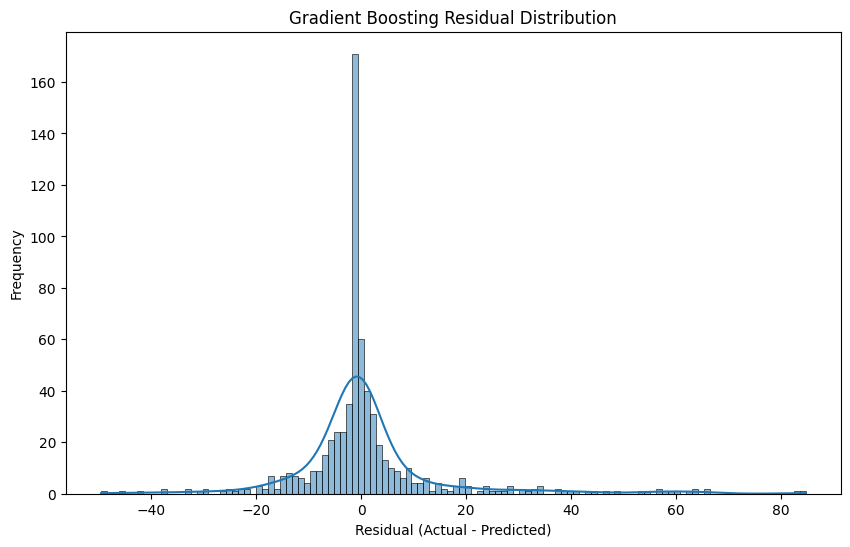

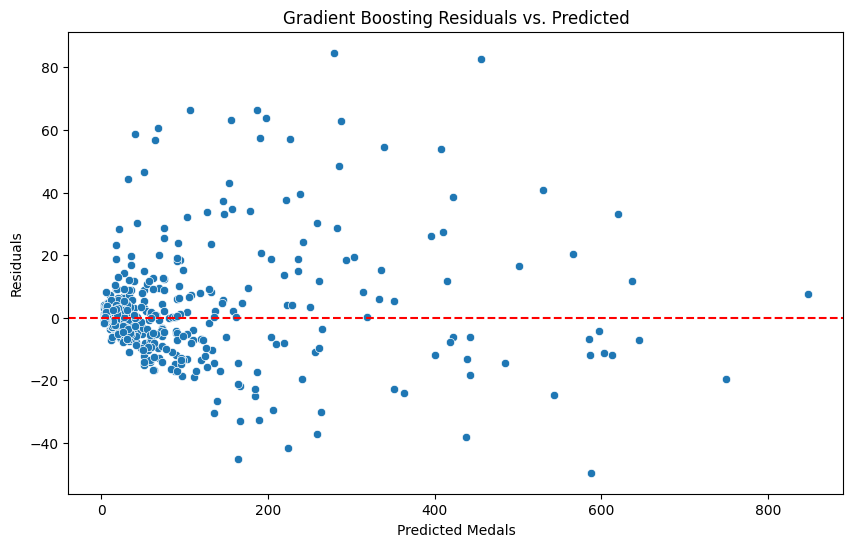

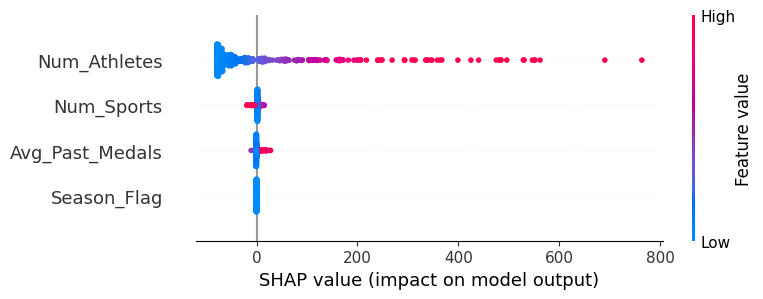

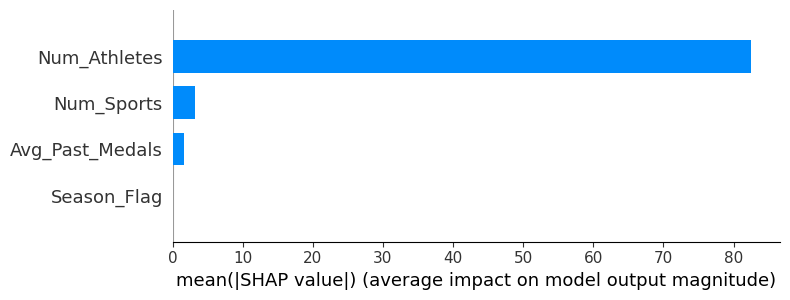

Final Model Performance:
Gradient Boosting - MSE: 203.8670, MAE: 7.4946, R²: 0.9869


In [8]:
# Step 10: Residual Analysis
# ---------------------------------------------------------------
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title(f"{model_name} Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f"{model_name} Residuals vs. Predicted")
plt.xlabel("Predicted Medals")
plt.ylabel("Residuals")
plt.show()

# Step 11: SHAP Analysis
# ---------------------------------------------------------------
# SHAP for Tree-based Models
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# Bar Plot of Mean |SHAP| values
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=features)

# Step 12: Results
# ---------------------------------------------------------------
final_mse, final_mae, final_r2 = evaluate_model(final_model, X_test, y_test)
print("Final Model Performance:")
print(f"{model_name} - MSE: {final_mse:.4f}, MAE: {final_mae:.4f}, R²: {final_r2:.4f}")